The task of the following notebook is to predict a transaction price of residential property in Singapore, based on its parameters, such as Location, Area (sqm), etc.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

In [2]:
# load train data
train_raw = pd.read_csv('residential_transactions_bishan_train.csv', index_col='Sale Date', parse_dates=True)
test_raw = pd.read_csv('residential_transactions_bishan_test.csv', index_col='Sale Date', parse_dates=True)
print 'Train data shape: {0}, test data shape: {1}'.format(train_raw.shape, test_raw.shape)

Train data shape: (3147, 12), test data shape: (371, 12)


The training set `residential_transactions_bishan_train.csv` contains committed transactions of residential properties in Singapore (from 2005). Test set `residential_transactions_bishan_test.csv` is a subsample from that period.

In [3]:
out = train_raw.rename(index=str, columns={"Unit Price ($ psm)": "Unit Price, psm", "Unit Price ($ psf)": "Unit Price, psf"})
out.head()

,Project Name,Address,Area (sqm),Type of Area,Transacted Price ($),"Unit Price, psm","Unit Price, psf",Property Type,Tenure,Completion Date,Type of Sale,Postal Code
Sale Date,,,,,,,,,,,,
2011-08-23 00:00:00,THOMSON GRAND,11 Sin Ming Walk #05-01,88,Strata,1284408,14596,1356,Condominium,99 Yrs From 08/02/2010,Uncompleted,New Sale,575579
2008-07-16 00:00:00,CLOVER BY THE PARK,6 Bishan Street 25 #37-14,119,Strata,1091000,9168,852,Condominium,99 Yrs From 10/09/2007,Uncompleted,New Sale,573975
2005-08-27 00:00:00,THE GARDENS AT BISHAN,7 Sin Ming Walk #15-18,112,Strata,636000,5679,528,Condominium,99 Yrs From 22/03/1997,2004,Resale,575577
2012-05-08 00:00:00,SKY HABITAT,9 Bishan Street 15 #08-15,95,Strata,1555910,16378,1522,Condominium,99 Yrs From 30/05/2011,Uncompleted,New Sale,573909
2007-06-13 00:00:00,ADELPHI PARK ESTATE,17 Carnation Drive,450,Land,2950000,6551,609,Detached House,Freehold,1991,Resale,579545


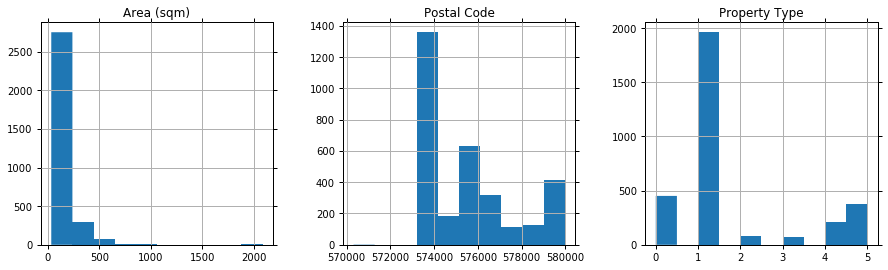

In [4]:
target_name =  'Transacted Price ($)'
cols_to_drop = ['Unit Price ($ psm)', 'Unit Price ($ psf)', 'Tenure', 'Completion Date']
cols_to_encode = ['Project Name', 'Type of Area', 'Property Type', 'Type of Sale']
cols_to_exclude = ['Address']

# drop 'useless' columns
train = train_raw.drop(cols_to_drop, axis=1)
test = test_raw.drop(cols_to_drop, axis=1)

# convert categorical data into numbers
_all_encoders = np.ndarray(shape=(len(cols_to_encode),), dtype=object)
for idx, column in enumerate(cols_to_encode):
    le = LabelEncoder()
    train[column] = le.fit_transform(train.loc[:, column].values)
    test[column] = le.transform(test.loc[:, column].values)
    _all_encoders[idx] = le

# draw histograms - yaxis is a number of transactions for each bin
axes = train[['Postal Code', 'Area (sqm)', 'Property Type']].hist(layout=(1,3),  figsize=(15,4))

In [5]:
cols_remain = [c for c in train.columns if c not in cols_to_exclude]
train = train[cols_remain]
test = test[cols_remain]

# don't use outliers for training
train = train[(train['Area (sqm)'].astype(int) < 500) & (train['Area (sqm)'].astype(int) > 0)]

# remove outliers for testing for better visualization
test = test[test[target_name].astype(int) < 1.5e7]

# split X and y
X_train = train.drop(target_name, axis=1).values
y_train = train[target_name].values

X_test = test.drop(target_name, axis=1).values
y_test = test[target_name].values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3091, 6), (3091,), (370, 6), (370,))

Use the LinearRegression class from sklearn.linear_model to fit a linear model predicting price from the features, prepared above. 

In [6]:
LR = LinearRegression().fit(X_train, y_train)

Now we can measure the prediction accuracy on the training set first.

In [7]:
predicted = LR.predict(X_train)
print 'Mean absolute percentage train error: {:0.2f}%'.format(np.mean(np.abs(y_train - predicted) / y_train) * 100)

Mean absolute percentage train error: 30.24%


(Text(0,0.5,u'Transacted Price ($)'), Text(0.5,0,u'Area (sqm)'))

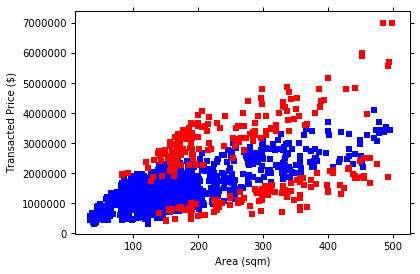

In [8]:
trainingErrs = abs(LR.predict(X_train) - y_train)

# draw outliers of train data prediction (with respect to Area), i.e. prediction error is large
outlierIdx = trainingErrs >= np.percentile(trainingErrs, 90)
plt.scatter(train['Area (sqm)'], y_train, c=(0,0,1), marker='s')
plt.scatter(train['Area (sqm)'][outlierIdx], y_train[outlierIdx], c=(1,0,0), marker='s')
plt.ylabel('Transacted Price ($)'), plt.xlabel('Area (sqm)')

Same analysis of the prediction accuracy on the test set.

In [9]:
predicted = LR.predict(X_test)
print 'Mean absolute percentage test error: {:0.2f}%'.format(np.mean(np.abs(y_test - predicted) / y_test) * 100)

Mean absolute percentage test error: 29.96%


(array([ 165.,  101.,   47.,   25.,   11.,    7.,    4.,    2.,    2.,
           1.,    1.,    1.,    1.,    0.,    0.,    0.,    1.,    0.,
           0.,    1.]),
 array([  1.69546530e+03,   2.33003299e+05,   4.64311133e+05,
          6.95618967e+05,   9.26926800e+05,   1.15823463e+06,
          1.38954247e+06,   1.62085030e+06,   1.85215814e+06,
          2.08346597e+06,   2.31477380e+06,   2.54608164e+06,
          2.77738947e+06,   3.00869730e+06,   3.24000514e+06,
          3.47131297e+06,   3.70262081e+06,   3.93392864e+06,
          4.16523647e+06,   4.39654431e+06,   4.62785214e+06]),
 <a list of 20 Patch objects>)

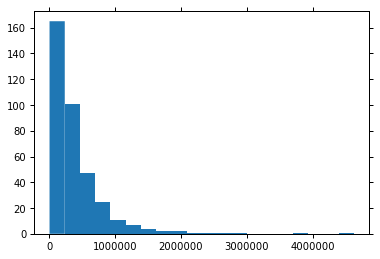

In [10]:
errs = abs(LR.predict(X_test) - y_test)
plt.hist(errs, bins=20)

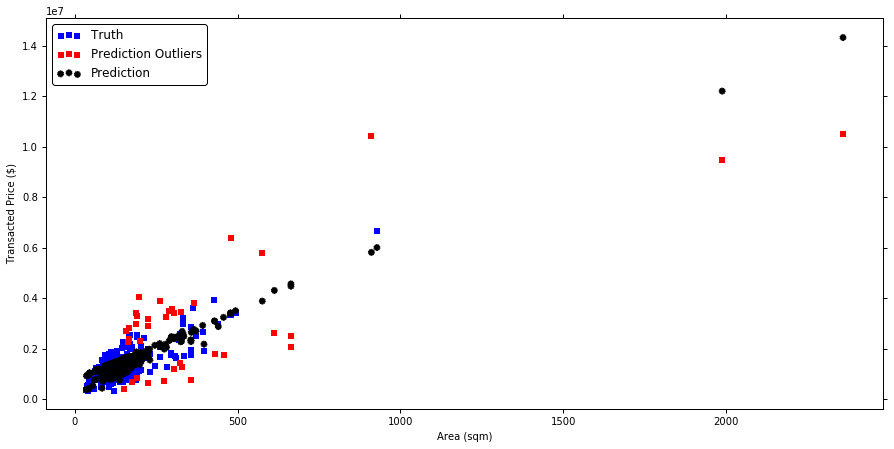

In [11]:
outlierIdx = errs >= np.percentile(errs, 90)
plt.figure(figsize=(15,7))
p1 = plt.scatter(test['Area (sqm)'], y_test, c=(0,0,1), marker='s')
p2 = plt.scatter(test['Area (sqm)'][outlierIdx], y_test[outlierIdx], c=(1,0,0), marker='s')
p3 = plt.scatter(test['Area (sqm)'], predicted, color='black', linewidth=1, linestyle=':')
plt.ylabel('Transacted Price ($)'), plt.xlabel('Area (sqm)')
plt.legend([p1, p2, p3], ['Truth', 'Prediction Outliers', 'Prediction'])